In [ ]:
from helpers import helper_functions
import time
import os

import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

In [242]:
#root_dir='/global/cscratch1/sd/abbatej/autoruns/mar2_no_0d/num_layers_2'
#root_dir='/global/homes/a/abbatej/plasma_profiles_predictor/test_models'
root_dir='/global/homes/a/abbatej/plasma_profiles_predictor'
input_dir='/global/homes/a/abbatej/'
model_filename='model.h5'
#model_filename='gru_cnn_renormed_40.h5'
rho_points = helper_functions.load_obj(input_dir+'rho_standard')

In [243]:
sig_names = ['Target current (A)', 'Injected power (kW)', 'Injected torque (Nm)']#, 'Gas A']
sig_keys = ['curr_target', 'pinj', 'tinj']
num_sigs=len(sig_names)

In [244]:
# matplotlib setup
%matplotlib inline

In [245]:
train_data = np.array(helper_functions.load_obj(input_dir+'train_data'))
train_target = np.array(helper_functions.load_obj(input_dir+'train_target'))
val_data = np.array(helper_functions.load_obj(input_dir+'val_data'))
val_target = np.array(helper_functions.load_obj(input_dir+'val_target'))

In [246]:
shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
train_shots = shot_indices_dictionary['train_shot_names']
val_shots = shot_indices_dictionary['val_shot_names']
train_shot_inds = shot_indices_dictionary['train_shot_indices']
val_shot_inds = shot_indices_dictionary['val_shot_indices']

In [247]:
train_time = np.array(helper_functions.load_obj(input_dir+'train_time'))
val_time = np.array(helper_functions.load_obj(input_dir+'val_time'))

In [248]:
means = helper_functions.load_obj(input_dir+'means')
stds = helper_functions.load_obj(input_dir+'stds')

In [249]:
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')

In [250]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 33)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 40)                8880      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
Total params: 10,110
Trainable params: 10,110
Non-trainable params: 0
_________________________________________________________________


In [258]:
# Get ML model performance
input_data=val_data.copy()
#val_mae = [abs(loaded_model.predict(input_data[timestep:timestep+1])-val_target[timestep]) for timestep in range(len(val_data))]
input_data[:,:,:3]=0
val_mae_holdout = [abs(loaded_model.predict(input_data[timestep:timestep+1])-val_target[timestep]) for timestep in range(len(val_data))]



In [252]:
avg_val_mae=np.mean(val_mae, axis=0)[0]
std_val_mae=np.std(val_mae, axis=0)[0]

In [259]:
avg_val_mae_holdout=np.mean(val_mae_holdout, axis=0)[0]
std_val_mae_holdout=np.std(val_mae_holdout, axis=0)[0]

In [254]:
# Get performance based on simply guessing the previous timestep
baseline_mae=[abs(val_data[timestep,-1,num_sigs:]-val_target[timestep]) for timestep in range(len(val_data))]

In [255]:
avg_baseline_mae=np.mean(baseline_mae, axis=0)
std_baseline_mae=np.std(baseline_mae, axis=0)

In [256]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

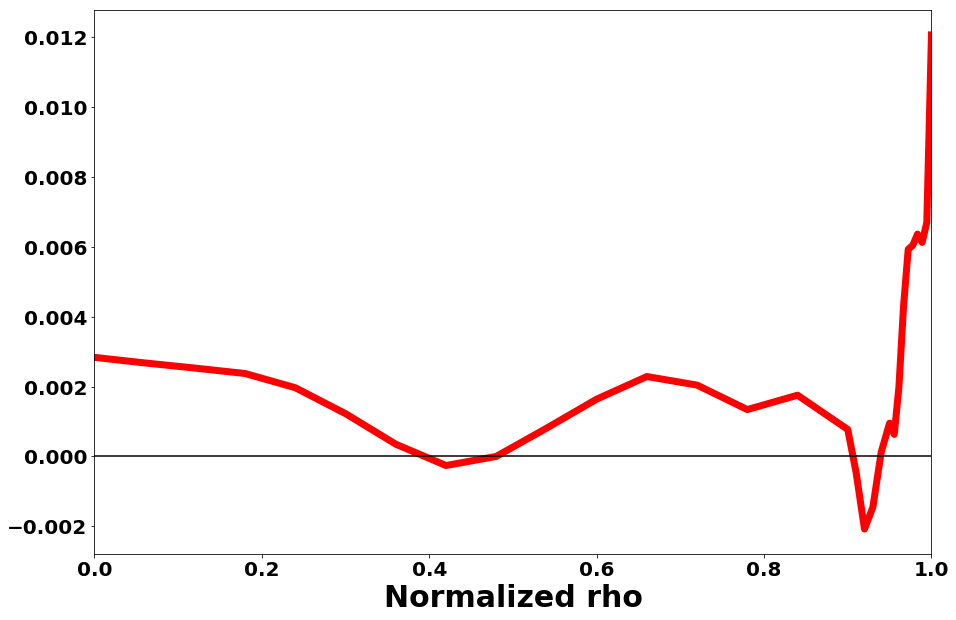

In [260]:
#plt.errorbar(list(range(22)),avg_val_mae, yerr=std_val_mae,c='orange', alpha=.5)
#plt.errorbar(list(range(22)), avg_baseline_mae, yerr=std_baseline_mae, c='b', alpha=.5)
#plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
#plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

#plt.plot(rho_points, avg_baseline_mae, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,avg_val_mae-avg_val_mae_holdout, c='r', label='ML', linewidth=7.0)
#plt.plot(rho_points,avg_val_mae_holdout, c='b', label='ML no actuators', linewidth=7.0)

#leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
#plt.title('Comparing prediction error with and without rho=30', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
#plt.ylabel('(Model with rho=30) - (Model without rho=30)', fontweight='heavy', fontsize=30)
plt.axhline(0,c='k')
#plt.ylim(0,.4)
plt.xlim(0,1.0)
plt.show()

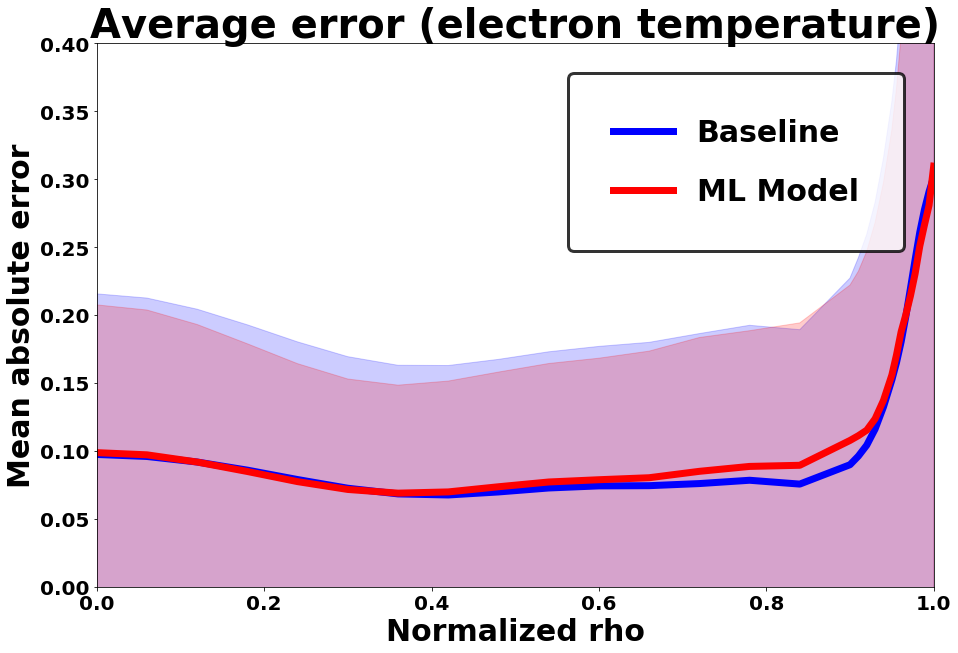

In [257]:
#plt.errorbar(list(range(22)),avg_val_mae, yerr=std_val_mae,c='orange', alpha=.5)
#plt.errorbar(list(range(22)), avg_baseline_mae, yerr=std_baseline_mae, c='b', alpha=.5)
plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

plt.plot(rho_points, avg_baseline_mae, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,avg_val_mae, c='r', label='ML Model', linewidth=7.0)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
plt.title('Average error (electron temperature)', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
plt.ylabel('Mean absolute error', fontweight='heavy', fontsize=30)
plt.ylim(0,.4)
plt.xlim(0,1.0)
plt.show()

In [162]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_timestep(timestep, train=False):
    
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))
    
    true_times = train_time if train else val_time

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))
    true=target[timestep]
    prev=data[timestep][-1][num_sigs:]
    
    pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
    true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
    prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:num_sigs] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred,label='Predicted', linewidth=smalllinewidth)
    ax.plot(rho_points,true,label='True', linewidth=smalllinewidth)
    ax.plot(rho_points,prev,label='Previous', linewidth=smalllinewidth)
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.4)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)
    
    for i in range(num_sigs):
        which_plot='{}2{}'.format(len(sigs),2*i+1)
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        ax.plot(true_times[times],(sigs_all_times[i]*stds[sig_keys[i]])+means[sig_keys[i]])
        ax.set_ylabel(sig_names[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        if i==num_sigs-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {}'.format(shot_num))
    plt.show()

In [16]:
plt.rcParams['figure.figsize'] = [20, 14]
font={'size': 20, 'weight': 'heavy'}
plt.rc('font', **font)

9754


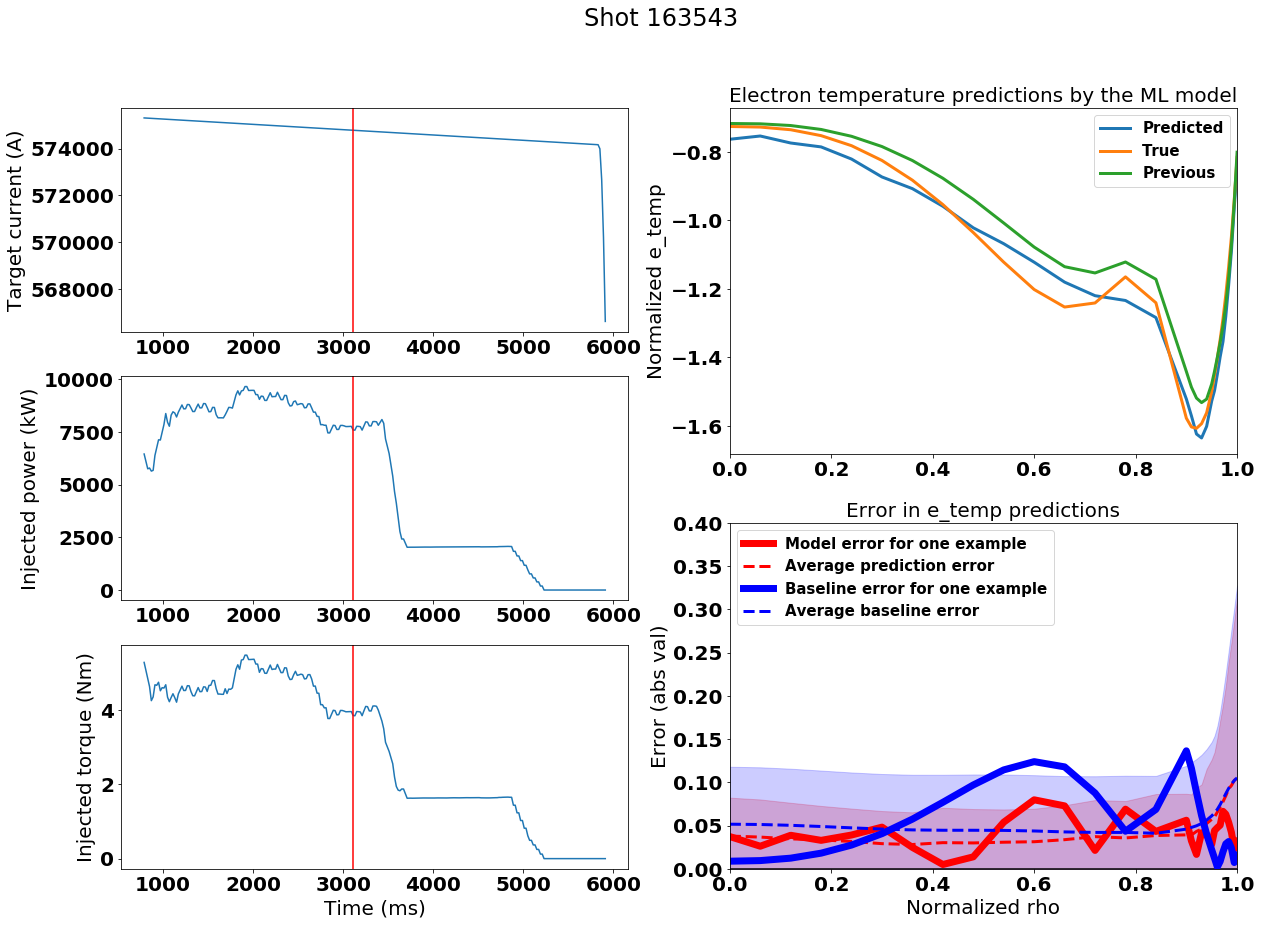

In [163]:
import random
timestep=9754 #random.randint(0,len(val_data))
print(timestep)
plot_timestep(timestep, train=False)

In [ ]:
timestep=170
plot_timestep(timestep, errors=False, train=False)

In [25]:
from IPython.display import clear_output

all_times=list(range(240,250))
k=1
for i in range(int(len(all_times)/k)):
    timestep=all_times[i*k]
    plot_timestep(timestep, train=True)
    time.sleep(3)
    clear_output()

NameError: name 'train_history' is not defined

In [ ]:
from IPython.display import clear_output

all_times=list(range(240,250))
k=1
for i in range(int(len(all_times)/k)):
    timestep=all_times[i*k]
    plot_errors(all_times, timestep, train=True)
    time.sleep(3)
    clear_output()